In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

from cnn import *
from Decoders import *
from utils import *

# device = torch.device("cpu")

MODEL TESTING

corpus

In [2]:
acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ౕ', 'ౖ', 'ౢ' ]
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers

bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu

print("Bases: ", len(bases))
print("Vms: ", len(vms))
print("Cms: ", len(cms))

characters = bases+vms+cms+connector

base_mapping = {}
i = 2
for x in bases:
  base_mapping[x] = i
  i+=1

vm_mapping = {}
i = 2
for x in vms:
  vm_mapping[x] = i
  i+=1

cm_mapping = {}
i = 2
for x in cms:
  cm_mapping[x] = i
  i+=1

  
# creates a list of ductionaries with each dictionary reporesenting a term
def wordsDicts(s):
  List = []
  for i in range(len(s)):
    x = s[i]
    prev = ''
    if i > 0: prev = s[i-1]
    #----------------------------------is it a base term-----------------------
    if((x in acchulu or x in hallulu)  and prev != connector[0]):
      List.append({})
      List[-1]['base'] = x
    #----------------------------if it is a consonant modifier-----------------
    elif x in hallulu and prev == connector[0]:
      if(len(List) == 0):
        print(x)
      if('cm' not in List[-1]): List[-1]['cm'] = []
      List[len(List)-1]['cm'].append(x)

      #---------------------------if it is a vowel modifier--------------------
    elif x in vallulu:
      if(len(List) == 0):
        print(x)

      if('vm' not in List[-1]): List[-1]['vm'] = []
      List[len(List)-1]['vm'].append(x)

      #----------------------------it is a spl character-----------------------
    elif x in spl:
      List.append({})
      List[len(List)-1]['base'] = x
    else:
      continue
  return List

Bases:  108
Vms:  19
Cms:  36


index encoding

In [3]:
def index_encoding(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [1]
    onehotvm1 =  [1]
    onehotvm2 =  [1]
    onehotvm3 =  [1]
    onehotvm4 =  [1]
    onehotcm1 =  [1]
    onehotcm2 =  [1]
    onehotcm3 =  [1]
    onehotcm4 =  [1]


    onehotbase[0] = base_mapping[D['base']]

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[0] = vm_mapping[j]
        elif it == 2:
          onehotvm2[0] = vm_mapping[j]
        elif it == 3:
          onehotvm3[0] = vm_mapping[j]
        elif it == 4:
          onehotvm4[0] = vm_mapping[j]
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[0] = cm_mapping[j]
        elif it == 2:
          onehotcm2[0] = cm_mapping[j]
        elif it == 3:
          onehotcm3[0] = cm_mapping[j]
        elif it == 4:
          onehotcm4[0] = cm_mapping[j]
        it += 1
    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 4*21 + 4*38 = 346
    onehot.append(onehoti)
  return torch.tensor(onehot)

def index_decoder(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]

    if onehoti[5] > 1:
      x += connector[0]
      x += cms[onehoti[5]-2]
    if onehoti[6] > 1:
      x += connector[0]
      x += cms[onehoti[6]-2]
    if onehoti[7] > 1:
      x += connector[0]
      x += cms[onehoti[7]-2]
    if onehoti[8] > 1:
      x += connector[0]
      x += cms[onehoti[8]-2]

    if onehoti[1] > 1:
      x += vms[onehoti[1]-2]
    if onehoti[2] > 1:
      x += vms[onehoti[2]-2]
    if onehoti[3] > 1:
      x += vms[onehoti[3]-2]
    if onehoti[4] > 1:
      x += vms[onehoti[4]-2]
  return x

one-hot-encoding

In [4]:
def one_hot_encoder(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [0 for _ in range(len(bases) + 2)]
    onehotvm1 =  [0 for _ in range(len(vms) + 2)]
    onehotvm2 =  [0 for _ in range(len(vms) + 2)]
    onehotvm3 =  [0 for _ in range(len(vms) + 2)]
    onehotvm4 =  [0 for _ in range(len(vms) + 2)]

    onehotcm1 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm2 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm3 =  [0 for _ in range(len(cms) + 2)]   
    onehotcm4 =  [0 for _ in range(len(cms) + 2)]   

    onehotbase[base_mapping[D['base']]] = 1

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[vm_mapping[j]] = 1
        elif it == 2:
          onehotvm2[vm_mapping[j]] = 1
        elif it == 3:
          onehotvm3[vm_mapping[j]] = 1
        elif it == 4:
          onehotvm4[vm_mapping[j]] = 1
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[cm_mapping[j]] = 1
        elif it == 2:
          onehotcm2[cm_mapping[j]] = 1
        elif it == 3:
          onehotcm3[cm_mapping[j]] = 1
        elif it == 4:
          onehotcm4[cm_mapping[j]] = 1
        it += 1


    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 4*21 + 4*38 = 346
    onehot.append(onehoti)
  encoded = torch.tensor(onehot).float().to(device)
  return encoded

def One_Hot_Decoder(List):
  x = ""
  for onehoti in List:
    for i in range(0, 110):
      if onehoti[i] == 1 and i > 1:
          x += bases[i-2]

    # for i in range(152, 190):
    #   if onehoti[i] == 1 and i > 195:
    #     x += connector[0]
    #     x += cms[i-196]
    # for i in range(190, 228):
    #   if onehoti[i] == 1 and i > 233:
    #     x += connector[0]
    #     x += cms[i-234]

    # for i in range(110, 131):
    #   if onehoti[i] == 1 and i > 111:
    #     x += vms[i-112]
    # for i in range(131, 152):
    #   if onehoti[i] == 1 and i > 132:
    #     x += vms[i-133]
  return x

In [5]:
def One_Hot_Decoder_Only_Base(List):
  x = ""
  for onehoti in List:
    if onehoti[0] == 1:
      x += '_'
      continue
    for i in range(0, 110):
      if onehoti[i] == 1 and i > 1:
          x += bases[i-2]
  return x

def One_Hot_Decoder_Only_Vm1(List):
  x = ""
  for onehoti in List:
    if onehoti[110] == 1:
      x += '_'
      continue
    if onehoti[111] == 1:
      x += ' '
      continue
    for i in range(110, 131):
      if onehoti[i] == 1 and i > 111:
        x += vms[i-112]
  return x

def One_Hot_Decoder_Only_Vm2(List):
  x = ""
  for onehoti in List:
    if onehoti[131] == 1:
      x += '_'
      continue
    if onehoti[132] == 1:
      x += ' '
      continue
    for i in range(131, 152):
      if onehoti[i] == 1 and i > 132:
        x += vms[i-133]
  return x

def One_Hot_Decoder_Only_Vm3(List):
  x = ""
  for onehoti in List:
    if onehoti[152] == 1:
      x += '_'
      continue
    if onehoti[153] == 1:
      x += ' '
      continue
    for i in range(152, 173):
      if onehoti[i] == 1 and i > 153:
        x += vms[i-154]
  return x

def One_Hot_Decoder_Only_Vm4(List):
  x = ""
  for onehoti in List:
    if onehoti[173] == 1:
      x += '_'
      continue
    if onehoti[174] == 1:
      x += ' '
      continue
    for i in range(173, 194):
      if onehoti[i] == 1 and i > 174:
        x += vms[i-175]
  return x

def One_Hot_Decoder_Only_Cm1(List):
  x = ""
  for onehoti in List:
    if onehoti[194] == 1:
      x += '_'
      continue
    if onehoti[195] == 1:
      x += ' '
      continue
    for i in range(194, 232):
      if onehoti[i] == 1 and i > 195:
        x += connector[0]
        x += cms[i-196]
  return x

def One_Hot_Decoder_Only_Cm2(List):
  x = ""
  for onehoti in List:
    if onehoti[232] == 1:
      x += '_'
      continue
    if onehoti[233] == 1:
      x += ' '
      continue
    for i in range(232, 270):
      if onehoti[i] == 1 and i > 233:
        x += connector[0]
        x += cms[i-234]
  return x

def One_Hot_Decoder_Only_Cm3(List):
  x = ""
  for onehoti in List:
    if onehoti[270] == 1:
      x += '_'
      continue
    if onehoti[271] == 1:
      x += ' '
      continue
    for i in range(270, 308):
      if onehoti[i] == 1 and i > 271:
        x += connector[0]
        x += cms[i-272]
  return x

def One_Hot_Decoder_Only_Cm4(List):
  x = ""
  for onehoti in List:
    if onehoti[308] == 1:
      x += '_'
      continue
    if onehoti[309] == 1:
      x += ' '
      continue
    for i in range(308, 346):
      if onehoti[i] == 1 and i > 309:
        x += connector[0]
        x += cms[i-310]
  return x



def index_decoder_Only_Base(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]
  return x

In [6]:
s = "అందరికి నమస్కారం"
print(s)
print(index_decoder(index_encoding(s)))
print(One_Hot_Decoder(one_hot_encoder(s)))

అందరికి నమస్కారం
అందరికి నమస్కారం
అదరక నమసర


In [7]:
cnn = CRNN_ENCODER().to(device)
rnn = Decoder_Trans_New().to(device)

cnn.load_state_dict(torch.load("/home/ocr/teluguOCR/Models/CNN/ModelTrans_E_TO_E2.pth"))
rnn.load_state_dict(torch.load("/home/ocr/teluguOCR/Models/RNN/ModelTrans_E_TO_E2.pth"))

cnn.eval()
rnn.eval()

Decoder_Trans_New(
  (embedding): Linear(in_features=50, out_features=64, bias=False)
  (transformerEncoderLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=512, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (transformerEncoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=

/home/ocr/anaconda3/envs/teluguOCR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 74, 276])
tensor(1.) tensor(0.)


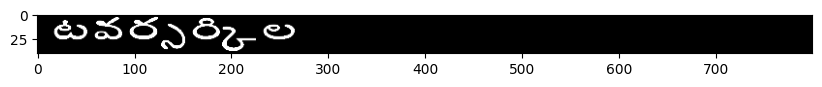

In [8]:
# load a JPEG image an convert to tensor
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2 as cv

img = Image.open("/home/ocr/teluguOCR/test7.png")
img = img.convert('L')

img = transforms.ToTensor()(img)
# img = image_tensor[0, 610:690, 160:405]

print(img.shape)
print(torch.max(img), torch.min(img))
img *= 255

img = Image.fromarray(np.array(img[0], dtype=np.uint8))

m = img.size[1]//40

img = img.resize((img.size[0]//m, 40))

img = transforms.ToTensor()(img)
img [img< 0] = 0
img [img> 255] = 255

img*= 255

img = 255 - img

th = 100
img[img > th] = 255
# img[img < th] = 0

f_img = torch.zeros(40, 800)

f_img[:, 0:img.shape[2]] = img[0]

plt.figure(figsize=(10,10))
plt.imshow(f_img[:, :], cmap='gray')
plt.show()

In [9]:
# f_img = f_img.unsqueeze(0).unsqueeze(0).to(device)
print(f_img.shape)
f_img = f_img.unsqueeze(0).unsqueeze(0).to(device)
print(f_img.shape)

f_out = cnn(f_img)

f_out = rnn(f_out)

print(f_out.shape)

f_output_sm = torch.zeros(1, Image_length, 110).to(device)

f_output_sm[:, :, 0:110] = F.softmax(f_out[:, :, 0:110], dim=2)
# f_output_sm[:, :, 110:131] = F.softmax(f_out[:, :, 110:131], dim=2)
# f_output_sm[:, :, 131:152] = F.softmax(f_out[:, :, 131:152], dim=2)
# f_output_sm[:, :, 152:190] = F.softmax(f_out[:, :, 152:190], dim=2)
# f_output_sm[:, :, 190:228] = F.softmax(f_out[:, :, 190:228], dim=2)

f_output_sm = f_output_sm.squeeze(0)

final_label = torch.zeros(Image_length, Text_embedding_size).to(device)

for i in range(Image_length):
    final_label[i, torch.argmax(f_output_sm[i, :110])] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 110:131])+110] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 131:152])+131] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 152:190])+152] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 190:228])+190] = 1

print("predicted label: ", One_Hot_Decoder(final_label))


torch.Size([40, 800])
torch.Size([1, 1, 40, 800])
torch.Size([1, 100, 110])
predicted label:  


In [10]:
for i in range(100):
    if(final_label[i][0] == 1):
        print('_', end = '')
    else:
        print(One_Hot_Decoder_Only_Base(final_label[i][:110].unsqueeze(0)), end = '')
print()

base = []
vm1 = []
vm2 = []
vm3 = []
vm4 = []
cm1 = []
cm2 = []
cm3 = []
cm4 = []

for i in range(100):
    base.append(One_Hot_Decoder_Only_Base(final_label[i].unsqueeze(0)))
    # vm1.append(One_Hot_Decoder_Only_Vm1(final_label[i].unsqueeze(0)))
    # vm2.append(One_Hot_Decoder_Only_Vm2(final_label[i].unsqueeze(0)))
    # vm3.append(One_Hot_Decoder_Only_Vm3(final_label[i].unsqueeze(0)))
    # vm4.append(One_Hot_Decoder_Only_Vm4(final_label[i].unsqueeze(0)))
    # cm1.append(One_Hot_Decoder_Only_Cm1(final_label[i].unsqueeze(0)))
    # cm2.append(One_Hot_Decoder_Only_Cm2(final_label[i].unsqueeze(0)))
    # cm3.append(One_Hot_Decoder_Only_Cm3(final_label[i].unsqueeze(0)))
    # cm4.append(One_Hot_Decoder_Only_Cm4(final_label[i].unsqueeze(0)))

# print(base)
# print(vm1)
# print(vm2)
# print(vm3)
# print(vm4)
# print(cm1)
# print(cm2)
# print(cm3)
# print(cm4)

# Removing the continuous duplicate occurances of the same character in the Lists
base = [base[i] for i in range(len(base)) if i == 0 or base[i] != base[i-1]]
# vm1 = [vm1[i] for i in range(len(vm1)) if i == 0 or vm1[i] != vm1[i-1]]
# vm2 = [vm2[i] for i in range(len(vm2)) if i == 0 or vm2[i] != vm2[i-1]]
# vm3 = [vm3[i] for i in range(len(vm3)) if i == 0 or vm3[i] != vm3[i-1]]
# vm4 = [vm4[i] for i in range(len(vm4)) if i == 0 or vm4[i] != vm4[i-1]]
# cm1 = [cm1[i] for i in range(len(cm1)) if i == 0 or cm1[i] != cm1[i-1]]
# cm2 = [cm2[i] for i in range(len(cm2)) if i == 0 or cm2[i] != cm2[i-1]]
# cm3 = [cm3[i] for i in range(len(cm3)) if i == 0 or cm3[i] != cm3[i-1]]
# cm4 = [cm4[i] for i in range(len(cm4)) if i == 0 or cm4[i] != cm4[i-1]]

# removing all occurances fo '' in the Lists
base = [x for x in base if x != '_']
# vm1 = [x for x in vm1 if x != '_']
# vm2 = [x for x in vm2 if x != '_']
# vm3 = [x for x in vm3 if x != '_']
# vm4 = [x for x in vm4 if x != '_']
# cm1 = [x for x in cm1 if x != '_']
# cm2 = [x for x in cm2 if x != '_']
# cm3 = [x for x in cm3 if x != '_']
# cm4 = [x for x in cm4 if x != '_']

print(len(base), " | ", base)
# print(len(vm1), " | ", vm1)
# print(len(vm2), " | ", vm2)
# print(len(vm3), " | ", vm3)
# print(len(vm4), " | ", vm4)
# print(len(cm1), " | ", cm1)
# print(len(cm2), " | ", cm2)
# print(len(cm3), " | ", cm3)
# print(len(cm4), " | ", cm4)

x = ""
for i in range(len(base)):
    x += base[i]
    if base[i] == ' ':
      continue

    # if i < len(cm1) and  cm1[i] != ' ':
    #   x += cm1[i]
    # if i < len(cm2) and  cm2[i] != ' ':
    #   x += cm2[i]
    # if i < len(cm3) and  cm3[i] != ' ':
    #   x += cm3[i]
    # if i < len(cm4) and  cm4[i] != ' ':
    #   x += cm4[i]

    # if i < len(vm1) and  vm1[i] != ' ':
    #   x += vm1[i]
    # if i < len(vm2) and  vm2[i] != ' ':
    #   x += vm2[i]
    # if i < len(vm3) and  vm3[i] != ' ':
    #   x += vm3[i]
    # if i < len(vm4) and  vm4[i] != ' ':
    #   x += vm4[i]
      
print("x: ", x)

____________________________________________________________________________________________________
0  |  []
x:  


Image from data set

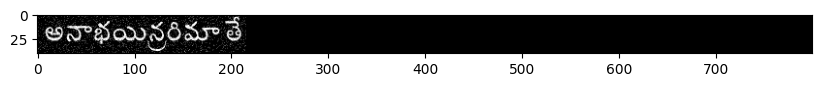

actual label:  అనాభయిన్రరిమా తే
predicted label:  


In [11]:
import matplotlib.pyplot as plt
import random

image_num = random.randint(1, 150854 + 1)

from dataset import *

data = TeluguOCRDataset("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Images", "/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels")

data_point = data.__getitem__(image_num)

image = data_point[0]
label = data_point[1]

image = image.to(device)
label = label.to(device)

plt.figure(figsize=(10,10))
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')
plt.show()

label = label.squeeze(0).cpu().to(torch.int64).numpy()

print("actual label: ", index_decoder(label))
image = image.unsqueeze(0).to(device)
f_output = cnn(image)

f_output = rnn(f_output)    

f_output_sm = torch.zeros(1, Image_length, 346).to(device)

f_output_sm[:, :, 0:110] = F.softmax(f_output[:, :, 0:110], dim=2)
# f_output_sm[:, :, 110:131] = F.softmax(f_output[:, :, 110:131], dim=2)
# f_output_sm[:, :, 131:152] = F.softmax(f_output[:, :, 131:152], dim=2)
# f_output_sm[:, :, 152:173] = F.softmax(f_output[:, :, 152:173], dim=2)
# f_output_sm[:, :, 173:194] = F.softmax(f_output[:, :, 173:194], dim=2)
# f_output_sm[:, :, 194:232] = F.softmax(f_output[:, :, 194:232], dim=2)
# f_output_sm[:, :, 232:270] = F.softmax(f_output[:, :, 232:270], dim=2)
# f_output_sm[:, :, 270:308] = F.softmax(f_output[:, :, 270:308], dim=2)
# f_output_sm[:, :, 308:346] = F.softmax(f_output[:, :, 308:346], dim=2)

f_output_sm = f_output_sm.squeeze(0)

final_label = torch.zeros(Image_length, Text_embedding_size).to(device)

for i in range(Image_length):
    final_label[i, torch.argmax(f_output_sm[i, :110])] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 110:131])+110] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 131:152])+131] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 152:173])+152] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 173:194])+173] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 194:232])+194] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 232:270])+232] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 270:308])+270] = 1
    # final_label[i, torch.argmax(f_output_sm[i, 308:346])+308] = 1

print("predicted label: ", One_Hot_Decoder(final_label))

In [ ]:
# printing the range values in f_output
print(torch.max(f_output[0, 0, :110]))
print(torch.min(f_output[0, 0, :110]))

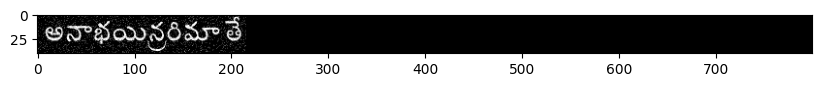

   Actual label:  అనాభయిన్రరిమా తే
100  |  ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']
Predicted Label:  

0  |  []


In [12]:
plt.figure(figsize=(10,10))
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')
plt.show()

print("   Actual label: ", index_decoder(label))

# for i in range(100):
#     if(final_label[i][0] == 1):
#         print('_', end = '')
#     else:
#         print(One_Hot_Decoder_Only_Base(final_label[i][:110].unsqueeze(0)), end = '')
# print()

base = []
# vm1 = []
# vm2 = []
# vm3 = []
# vm4 = []
# cm1 = []
# cm2 = []
# cm3 = []
# cm4 = []

for i in range(100):
    base.append(One_Hot_Decoder_Only_Base(final_label[i].unsqueeze(0)))
    # vm1.append(One_Hot_Decoder_Only_Vm1(final_label[i].unsqueeze(0)))
    # vm2.append(One_Hot_Decoder_Only_Vm2(final_label[i].unsqueeze(0)))
    # vm3.append(One_Hot_Decoder_Only_Vm3(final_label[i].unsqueeze(0)))
    # vm4.append(One_Hot_Decoder_Only_Vm4(final_label[i].unsqueeze(0)))
    # cm1.append(One_Hot_Decoder_Only_Cm1(final_label[i].unsqueeze(0)))
    # cm2.append(One_Hot_Decoder_Only_Cm2(final_label[i].unsqueeze(0)))
    # cm3.append(One_Hot_Decoder_Only_Cm3(final_label[i].unsqueeze(0)))
    # cm4.append(One_Hot_Decoder_Only_Cm4(final_label[i].unsqueeze(0)))

# print(base)
# print(vm1)
# print(vm2)
# print(vm3)
# print(vm4)
# print(cm1)
# print(cm2)
# print(cm3)
# print(cm4)
print(len(base), " | ", base)
# Removing the continuous duplicate occurances of the same character in the Lists
base = [base[i] for i in range(len(base)) if i == 0 or base[i] != base[i-1]]
# vm1 = [vm1[i] for i in range(len(vm1)) if i == 0 or vm1[i] != vm1[i-1]]
# vm2 = [vm2[i] for i in range(len(vm2)) if i == 0 or vm2[i] != vm2[i-1]]
# vm3 = [vm3[i] for i in range(len(vm3)) if i == 0 or vm3[i] != vm3[i-1]]
# vm4 = [vm4[i] for i in range(len(vm4)) if i == 0 or vm4[i] != vm4[i-1]]
# cm1 = [cm1[i] for i in range(len(cm1)) if i == 0 or cm1[i] != cm1[i-1]]
# cm2 = [cm2[i] for i in range(len(cm2)) if i == 0 or cm2[i] != cm2[i-1]]
# cm3 = [cm3[i] for i in range(len(cm3)) if i == 0 or cm3[i] != cm3[i-1]]
# cm4 = [cm4[i] for i in range(len(cm4)) if i == 0 or cm4[i] != cm4[i-1]]

# removing all occurances fo '' in the Lists
base = [x for x in base if x != '_']
# vm1 = [x for x in vm1 if x != '_']
# vm2 = [x for x in vm2 if x != '_']
# vm3 = [x for x in vm3 if x != '_']
# vm4 = [x for x in vm4 if x != '_']
# cm1 = [x for x in cm1 if x != '_']
# cm2 = [x for x in cm2 if x != '_']
# cm3 = [x for x in cm3 if x != '_']
# cm4 = [x for x in cm4 if x != '_']



x = ""
for i in range(len(base)):
    x += base[i]
    if base[i] == ' ':
      continue

    # if i < len(cm1) and  cm1[i] != ' ':
    #   x += cm1[i]
    # if i < len(cm2) and  cm2[i] != ' ':
    #   x += cm2[i]
    # if i < len(cm3) and  cm3[i] != ' ':
    #   x += cm3[i]
    # if i < len(cm4) and  cm4[i] != ' ':
    #   x += cm4[i]

    # if i < len(vm1) and  vm1[i] != ' ':
    #   x += vm1[i]
    # if i < len(vm2) and  vm2[i] != ' ':
    #   x += vm2[i]
    # if i < len(vm3) and  vm3[i] != ' ':
    #   x += vm3[i]
    # if i < len(vm4) and  vm4[i] != ' ':
    #   x += vm4[i]
      
print("Predicted Label: ", x, end = '\n\n')

print(len(base), " | ", base)
# print(len(vm1), " | ", vm1)
# print(len(vm2), " | ", vm2)
# print(len(vm3), " | ", vm3)
# print(len(vm4), " | ", vm4)
# print(len(cm1), " | ", cm1)
# print(len(cm2), " | ", cm2)
# print(len(cm3), " | ", cm3)
# print(len(cm4), " | ", cm4)

LOSS TESTING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CTCLoss(blank=0)

N = 500 #Batch size

target = torch.tensor([5, 5, 1, 7, 4, 10, 9, 6, 5, 3, 5]).unsqueeze(0)  # 1*5
target = target.expand(N, 11)  # N*5
input = torch.full((100, N, 11), -0.1, dtype=torch.float64)
input[0, :, 5] =  0.1 
input[1, :, 0] =  0.1  #
input[2, :, 0] =  0.1  #
input[3, :, 0] =  0.1  #
input[4, :, 5] =  0.1 
input[5, :, 0] =  0.1  #
input[6, :, 0] =  0.1  #
input[7, :, 0] =  0.1 
input[8, :, 1] =  0.1  #
input[9, :, 0] =  0.1  #
input[10, :, 7] =  0.1 
input[11, :, 0] =  0.1  #
input[12, :, 4] =  0.1 
input[13, :, 0] =  0.1  #
input[14, :, 10] =  0.1
input[15, :, 0] =  0.1  #
input[16, :, 9] =  0.1
input[17, :, 0] =  0.1  #
input[18, :, 6] =  0.1
input[19, :, 0] =  0.1  #
input[20, :, 5] =  0.1
input[21, :, 0] =  0.1  #
input[22, :, 3] =  0.1
input[23, :, 0] =  0.1  #
input[24, :, 5] =  0.1
input[25:, :, 0] =  0.1  #

input *= 100

input_lengths = torch.full(size=(N,), fill_value=100, dtype=torch.long)
target_lengths = torch.full(size=(N,), fill_value=11, dtype=torch.long)

input = input.log_softmax(2).detach().requires_grad_()

loss = criterion(input, target, input_lengths, target_lengths)
print(loss)

In [ ]:
input_round = torch.round(input)
# print(input_round)
for i in range(100):
    # print(input[i][0])
    if(input_round[i][0][0] == 1): continue
    for j in range(11):
        if(input_round[i][0][j] == 1):
            print(j)
            break

In [ ]:
from augraphy import *
import cv2
import matplotlib.pyplot as plt

pipeline = default_augraphy_pipeline()

num = 10

image = cv2.imread("/home/ocr/teluguOCR/Dataset/Images/Image" + str(num) + ".png")

image = 1 - image/255

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

augmented = pipeline(image)

plt.figure(figsize=(10,10))
plt.imshow(augmented)
plt.show()

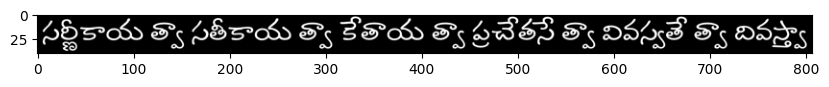

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(0, dtype=torch.uint8)
Inkbleed: 


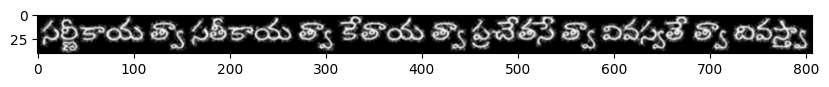

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(1, dtype=torch.uint8)
Double Exposure: 


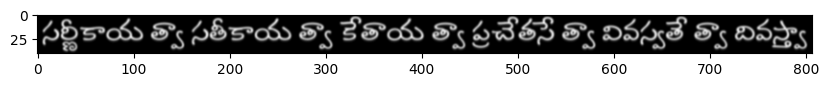

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(11, dtype=torch.uint8)
Hollow: 


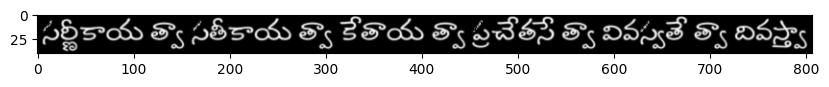

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(3, dtype=torch.uint8)
Letterpress: 


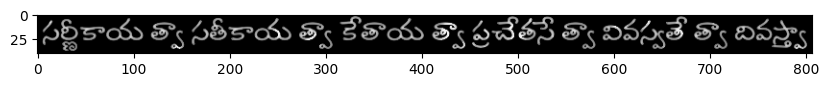

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(10, dtype=torch.uint8)
Lighting Gradient Linear Static: 


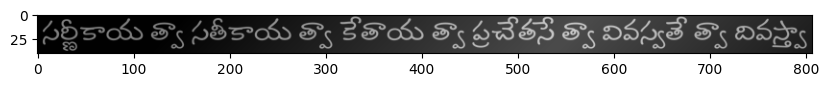

torch.Size([40, 807, 3])
tensor(254, dtype=torch.uint8)  |  tensor(53, dtype=torch.uint8)
Low Ink Periodic Line Consistent: 


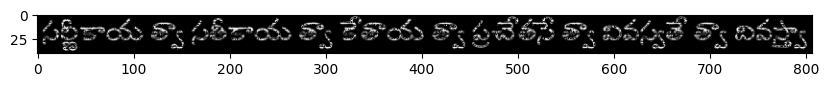

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(0, dtype=torch.uint8)
Shadowcast: 


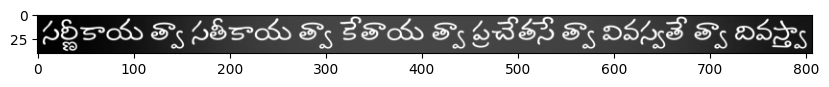

torch.Size([40, 807, 3])
tensor(253, dtype=torch.uint8)  |  tensor(0, dtype=torch.uint8)
Folding: 


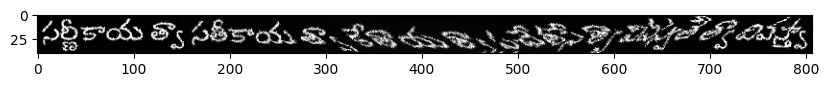

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(0, dtype=torch.uint8)
Book Binder Down: 


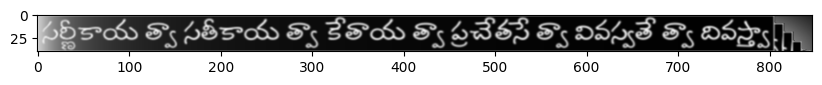

torch.Size([40, 847, 3])
tensor(254, dtype=torch.uint8)  |  tensor(7, dtype=torch.uint8)
(40, 807, 3)
Ink Shifter: 


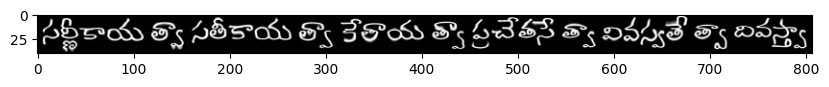

torch.Size([40, 807, 3])
tensor(255, dtype=torch.uint8)  |  tensor(0, dtype=torch.uint8)
torch.Size([40, 807, 1])
tensor(1., dtype=torch.float64)  |  tensor(0., dtype=torch.float64)
Gaussian Noise: 


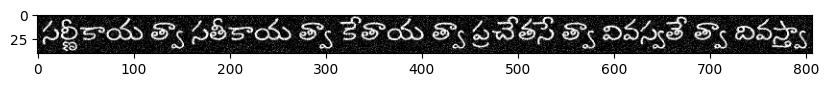

In [3]:
# import libraries
import cv2
import numpy as np
from augraphy import *
import matplotlib.pyplot as plt
import torch
import random
from skimage.util import random_noise
import torchvision.transforms as transforms

# read image
num = random.randint(1, 150854 + 1)
image = cv2.imread("/home/ocr/teluguOCR/Dataset/Images/Image" + str(num) + ".png")

# image = 255 - image

plt.figure(figsize=(10,10))
plt.imshow(255 - image)
plt.show()
print(torch.tensor(image).shape)
print(torch.max(torch.tensor(image))," | ", torch.min(torch.tensor(image)))

inkbleed = InkBleed(intensity_range=(0.2, 1),
                    kernel_size=(5, 5),
                    severity=(0.2, 0.4)
                    )

img_inkbleed = inkbleed(image)

print("Inkbleed: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_inkbleed)
plt.show()
print(torch.tensor(img_inkbleed).shape)
print(torch.max(torch.tensor(img_inkbleed))," | ", torch.min(torch.tensor(img_inkbleed)))

doubleexposure = DoubleExposure(gaussian_kernel_range=(2,3),
                                offset_direction=1,
                                offset_range=(2,4),
                                )

img_doubleexposure = doubleexposure(image)

print("Double Exposure: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_doubleexposure)
plt.show()
print(torch.tensor(img_doubleexposure).shape)
print(torch.max(torch.tensor(img_doubleexposure))," | ", torch.min(torch.tensor(img_doubleexposure)))

hollow = Hollow(hollow_median_kernel_value_range = (51, 51),
                hollow_min_width_range=(1, 1),
                hollow_max_width_range=(15, 15),
                hollow_min_height_range=(1, 1),
                hollow_max_height_range=(15, 15),
                hollow_min_area_range=(10, 10),
                hollow_max_area_range=(50, 50),
                hollow_dilation_kernel_size_range = (3, 3),
                )

img_hollow = hollow(image)

print("Hollow: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_hollow)
plt.show()
print(torch.tensor(img_hollow).shape)
print(torch.max(torch.tensor(img_hollow))," | ", torch.min(torch.tensor(img_hollow)))


letterpress = Letterpress(n_samples=(20, 500),
                          n_clusters=(30, 80),
                          std_range=(150, 500),
                          value_range=(10, 15),
                          value_threshold_range=(128, 128),
                          blur=1
                          )

img_letterpress = letterpress(image)

print("Letterpress: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_letterpress)
plt.show()
print(torch.tensor(img_letterpress).shape)
print(torch.max(torch.tensor(img_letterpress))," | ", torch.min(torch.tensor(img_letterpress)))

lighting_gradient_linear_static = LightingGradient(light_position=None,
                                              direction=45,
                                              max_brightness=150,
                                              min_brightness=50,
                                              mode="linear_static",
                                              linear_decay_rate = 0.5,
                                              transparency=0.5
                                              )

img_lighting_gradient_linear_static = lighting_gradient_linear_static(image)

print("Lighting Gradient Linear Static: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_lighting_gradient_linear_static)
plt.show()
print(torch.tensor(img_lighting_gradient_linear_static).shape)
print(torch.max(torch.tensor(img_lighting_gradient_linear_static))," | ", torch.min(torch.tensor(img_lighting_gradient_linear_static)))

low_ink_periodic_line_consistent =  LowInkPeriodicLines(count_range=(1, 5),
                                                        period_range=(1, 4),
                                                        use_consistent_lines=False,
                                                        noise_probability=0.02,
                                                        )

img_low_ink_periodic_line_consistent = low_ink_periodic_line_consistent(image)

print("Low Ink Periodic Line Consistent: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_low_ink_periodic_line_consistent)
plt.show()
print(torch.tensor(img_low_ink_periodic_line_consistent).shape)
print(torch.max(torch.tensor(img_low_ink_periodic_line_consistent))," | ", torch.min(torch.tensor(img_low_ink_periodic_line_consistent)))

shadowcast = ShadowCast(shadow_side = "bottom",
                        shadow_vertices_range = (2, 3),
                        shadow_width_range=(0.5, 0.8),
                        shadow_height_range=(0.5, 0.8),
                        shadow_color = (10, 10, 10),
                        shadow_opacity_range=(0.5,0.6),
                        shadow_iterations_range = (1,2),
                        shadow_blur_kernel_range = (101, 301),
                        )

img_shadowcast = shadowcast(image)

print("Shadowcast: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_shadowcast)
plt.show()
print(torch.tensor(img_shadowcast).shape)
print(torch.max(torch.tensor(img_shadowcast))," | ", torch.min(torch.tensor(img_shadowcast)))

folding = Folding(fold_count=3,
                  fold_noise=0.0,
                  fold_angle_range = (-360,360),
                  gradient_width=(0.1, 0.5),
                  gradient_height=(0.01, 0.05),
                  backdrop_color = (255,255,255),
                  )

img_folding = folding(image)

print("Folding: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_folding)
plt.show()
print(torch.tensor(img_folding).shape)
print(torch.max(torch.tensor(img_folding))," | ", torch.min(torch.tensor(img_folding)))

book_binder_down = BookBinding(shadow_radius_range=(100, 100),
                              curve_range_right=(1, 1),
                              curve_range_left=(1, 1),
                              curve_ratio_right = (1e-5, 1e-5),
                              curve_ratio_left = (1e-5, 1e-5),
                              mirror_range=(0, 0),
                              binding_align = 2,
                              binding_pages = (4,6),
                              curling_direction=0,
                              backdrop_color=(255, 255, 255),
                              enable_shadow=1,
                              use_cache_images = 0,
                              )


img_book_binder_down = book_binder_down(image)

img_book_binder_down = img_book_binder_down[:40]

print("Book Binder Down: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_book_binder_down)
plt.show()
print(torch.tensor(img_book_binder_down).shape)
print(torch.max(torch.tensor(img_book_binder_down))," | ", torch.min(torch.tensor(img_book_binder_down)))

inkshifter_obj = InkShifter(
    text_shift_scale_range=(2, 7),
    text_shift_factor_range=(1, 4),
    text_fade_range=(0, 2),
    noise_type = "random",
)

img_inkshifter = inkshifter_obj(image)

print(img_inkshifter.shape)
print("Ink Shifter: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - img_inkshifter)
plt.show()
print(torch.tensor(img_inkshifter).shape)
print(torch.max(torch.tensor(img_inkshifter))," | ", torch.min(torch.tensor(img_inkshifter)))


transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure PIL
    transforms.Grayscale(num_output_channels=1),  # Convert to single channel
    transforms.ToTensor()  # Convert to a PyTorch tensor
])

def add_gaussian_noise(img):
  img = transform(img).permute(1, 2, 0)
  img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.02, clip=True))
  return img

img_gauss = add_gaussian_noise(image)

print(torch.tensor(img_gauss).shape)
print(torch.max(torch.tensor(img_gauss))," | ", torch.min(torch.tensor(img_gauss)))

print("Gaussian Noise: ")
plt.figure(figsize=(10,10))
plt.imshow(255 - 255*img_gauss, cmap='gray')
plt.show()


In [ ]:
from PIL import Image
import torch 
import random
import matplotlib.pyplot as plt

num = random.randint(1, 154048 + 1)
print(num)

# types = torch.load("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/NoiseTypes.pt")
# print("Noise type: ", types[num-1])
image = torch.load("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Images/Image" + str(num) + ".pt")
label = torch.load("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels/Label" + str(num) + ".pt")

print(index_decoder(label))

print(image.shape)

plt.figure(figsize=(10,10))

plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
import os
import torch

Max = 0
for l in os.listdir("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels"):
    label = torch.load("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels/" + l)
    Max = max(Max, len(label))
    if len(label) > 45:
        print(l, " | ", len(label))

print(Max)

In [ ]:
# load the txt file and read the file line by line.
def read_file_lines(filename):
    lines = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                lines.append(line.strip())  # Remove trailing newline characters
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
    return lines

lines = read_file_lines("/home/ocr/teluguOCR/Dataset/strings.txt")

line = lines[10]
print(line)

print(index_encoding(line).shape[0])
print(len(index_encoding(line)))

In [ ]:
import torch
import os

Max = 0

for x in os.listdir("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels"):
    label = torch.load("/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Labels/" + x)
    Max = max(Max, len(label))

print(Max)